<a href="https://colab.research.google.com/github/isak-ow/PatternAnalysis-2023/blob/topic-recognition/ISIC_leisons_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=26cf1f3ce0a59f1c1f46dd4fe3fe3e72c669d3e792416f36c75354435a534e32
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
2594-round(2594*0.8)

519

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms
import torch
import wandb

class ISICdataset(Dataset):
    def __init__(self, image_dir, truth_dir, transform=True, target_size=(256, 256)):
        self.image_dir = image_dir
        self.truth_dir = truth_dir
        self.transform = transform
        self.target_size = target_size
        self.images = os.listdir(image_dir)

        self.images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

    def __getitem__(self, index):
      img_path = os.path.join(self.image_dir, self.images[index])
      truth_path = os.path.join(self.truth_dir, self.images[index].replace('.jpg', '_segmentation.png'))

      # Open and resize the image to the target size
      image = Image.open(img_path).convert('RGB')
      image = transforms.Resize(self.target_size)(image)

      # Open and resize the truth mask to the target size
      truth = Image.open(truth_path).convert('L')
      truth = transforms.Resize(self.target_size)(truth)

      image = transforms.ToTensor()(image)
      truth = transforms.ToTensor()(truth)
      image = transforms.Normalize([0,0,0],[1,1,1])(image)#[0.7084, 0.5822, 0.5361], [0.0948, 0.1099, 0.1240])(image)
      return image, truth

    def __len__(self):
        return len(self.images)

In [ ]:
import gdown
import zipfile

def get_data_from_url(destination_dir, google_drive_id):

  if not os.path.exists(destination_dir):
    compressed_data = 'ISIC_data.zip'
    url = f'https://drive.google.com/uc?id={google_drive_id}'
    gdown.download(url, compressed_data, quiet=False)

    with zipfile.ZipFile(compressed_data, 'r') as zip_ref:
      zip_ref.extractall()
    os.remove(compressed_data)

  else:
    print('Data already loaded')

def accuracy(preds, truths):
  with torch.no_grad():
    preds = (preds > 0.5).float()
    correct = (preds==truths).sum()
    pixels = torch.numel(preds)
    accuracy = correct / pixels + 1e-8

  return accuracy

In [ ]:
get_data_from_url('ISIC_data', '1vxd1KBIYa3zCAVONkacdclsWUAxhWLho')

Downloading...
From: https://drive.google.com/uc?id=1vxd1KBIYa3zCAVONkacdclsWUAxhWLho
To: /content/ISIC_data.zip
100%|██████████| 5.64G/5.64G [01:39<00:00, 56.5MB/s]


In [ ]:
from torch import nn
import torch
import torch.nn.functional as F

class ImprovedUNET(nn.Module):
  def __init__(self, n_channels, n_classes):
    super(ImprovedUNET, self).__init__()
    #first level down
    self._n_to_16_d = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1, padding=1)
    self._16_to_16_d = context_block(16, 16)
    #second layer down
    self._16_to_32_d = stride_layer(16, 32)
    self._32_to_32_d = context_block(32,32)
    #third layer down
    self._32_to_64_d = stride_layer(32, 64)
    self._64_to_64_d = context_block(64, 64)
    #fourth layer down
    self._64_to_128_d = stride_layer(64, 128)
    self._128_to_128_d = context_block(128, 128)
    #fifth layer down
    self._128_to_256_b = stride_layer(128, 256)
    self._256_to_256_b = context_block(256, 256)
    self._256_to_128_b = upsampling_block(256, 128)
    #fourth layer up
    self.c1_to_128_u = localization_block(256, 128)
    self._128_to_64_u = upsampling_block(128, 64)
    #third layer up
    self.c2_to_64_u = localization_block(128, 64)
    self._64_to_32_u = upsampling_block(64, 32)
    #second layer up
    self.c3_to_32_u = localization_block(64, 32)
    self._32_to_16_u = upsampling_block(32, 16)
    #first layer up
    self.c4_to_32_u = nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1)
    self.sigmoid = nn.Sigmoid()

    ##segmentation
    self.segmentation1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
    self.segmentation2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    self.segmentation3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
    self.scale1 = upsampling_block(32, 16,2)
    self.scale2 = upsampling_block(16,1,2,1,0)

  def forward(self, x):
    #context path
    x = self._n_to_16_d(x)
    r1 = x + self._16_to_16_d(x)

    x = self._16_to_32_d(r1)
    r2 = x + self._32_to_32_d(x)

    x = self._32_to_64_d(r2)
    r3 = x + self._64_to_64_d(x)

    x = self._64_to_128_d(r3)
    r4 = x + self._128_to_128_d(x)

    #bottom layer
    x = self._128_to_256_b(r4)
    x = x + self._256_to_256_b(x)
    x = self._256_to_128_b(x)

    #localization path
    x = torch.cat([x,r4],dim=1)
    x = self.c1_to_128_u(x)
    x = self._128_to_64_u(x)

    x = torch.cat([x,r3],dim=1)
    s1 = self.c2_to_64_u(x)
    x = self._64_to_32_u(s1)

    s1 = self.segmentation1(s1)
    s1 = self.scale1(s1)

    x = torch.cat([x,r2],dim=1)
    s2 = self.c3_to_32_u(x)
    x = self._32_to_16_u(s2)

    s2 = self.segmentation2(s2)
    s2 += s1
    s2 = self.scale2(s2)

    x = torch.cat([x,r1],dim=1)
    x = self.c4_to_32_u(x)

    x = s2 + self.segmentation3(x)
    x = self.sigmoid(x)

    return x

def context_block(in_channels, out_channels):
  return nn.Sequential(

      nn.InstanceNorm2d(in_channels),
      nn.LeakyReLU(negative_slope=0.01, inplace=True),
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),

      nn.Dropout2d(p=0.3),

      nn.InstanceNorm2d(in_channels),
      nn.LeakyReLU(negative_slope=0.01, inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
  )

def localization_block(in_channels, out_channels):
  return nn.Sequential(
      nn.LeakyReLU(negative_slope=0.01, inplace=True),
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(negative_slope=0.01, inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0),
      nn.BatchNorm2d(out_channels),
  )

def upsampling_block(in_channels, out_channels, scale_factor=2,kernel_size=3,padding=1):
  return nn.Sequential(
      nn.Upsample(scale_factor=scale_factor, mode='nearest'),
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
  )
def stride_layer(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
    )

In [ ]:
import torchvision.transforms as tt
from torch import nn
class DiceLoss(nn.Module):
  def __init__(self, smooth = 1.0):
    super(DiceLoss, self).__init__()
    self.smooth = smooth

  def forward(self, pred, truth):
    #pred = F.sigmoid(pred)
    pred_f = pred.view(-1)
    truth_f = truth.view(-1)

    overlap = (pred_f*truth_f).sum()
    dice = (2*overlap+self.smooth)/(pred_f.sum()+truth_f.sum()+self.smooth)
    return 1-dice

In [ ]:
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
# Initialize Dataset and Dataloader
image_dir = 'ISIC_data/train'
truth_dir = 'ISIC_data/ground_truth'
fulldataset = ISICdataset(image_dir, truth_dir)
n_elements = 2594
#splitting into training and validation sets
train_dataset, validation_dataset = random_split(fulldataset, [round(n_elements*0.8),n_elements- round(n_elements*0.8)])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

# Initialize Model, Loss and Optimizer
n_channels = 3 # RGB Images
n_classes = 1  # Background and Object
device = 'cuda'
model = ImprovedUNET(n_channels, n_classes).to(device)
model.load_state_dict(torch.load('drive/MyDrive/COMP3710/colab_run_checkpoints/checkpoint29.pth'))
criterion = DiceLoss() # DiceLoss()
lr_init = 0.001
weight_decay = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr_init, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lr_init * (0.998 ** epoch))

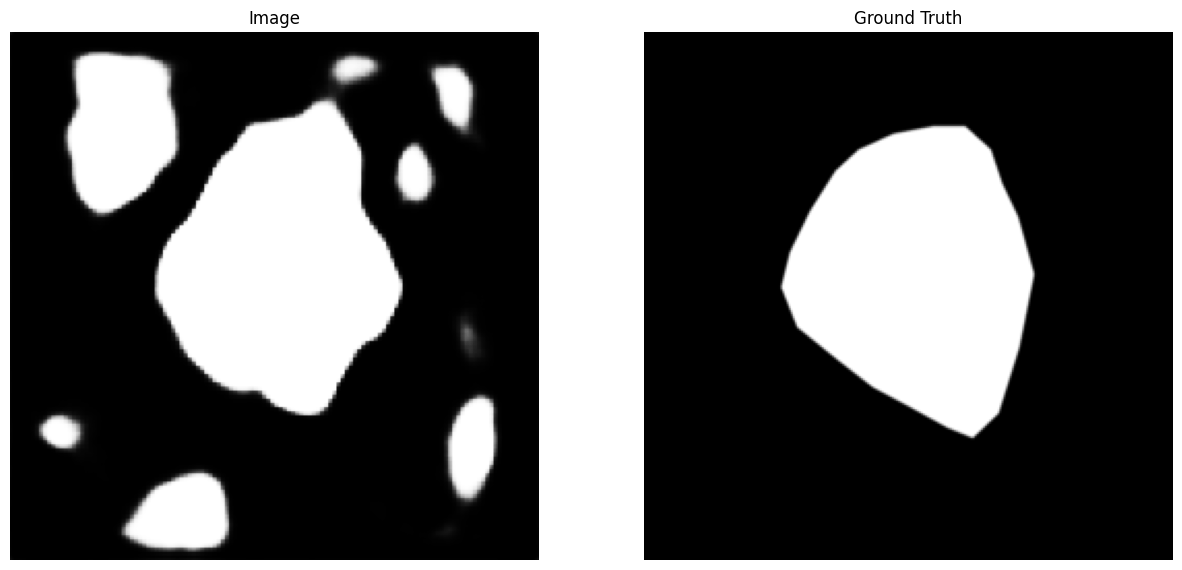

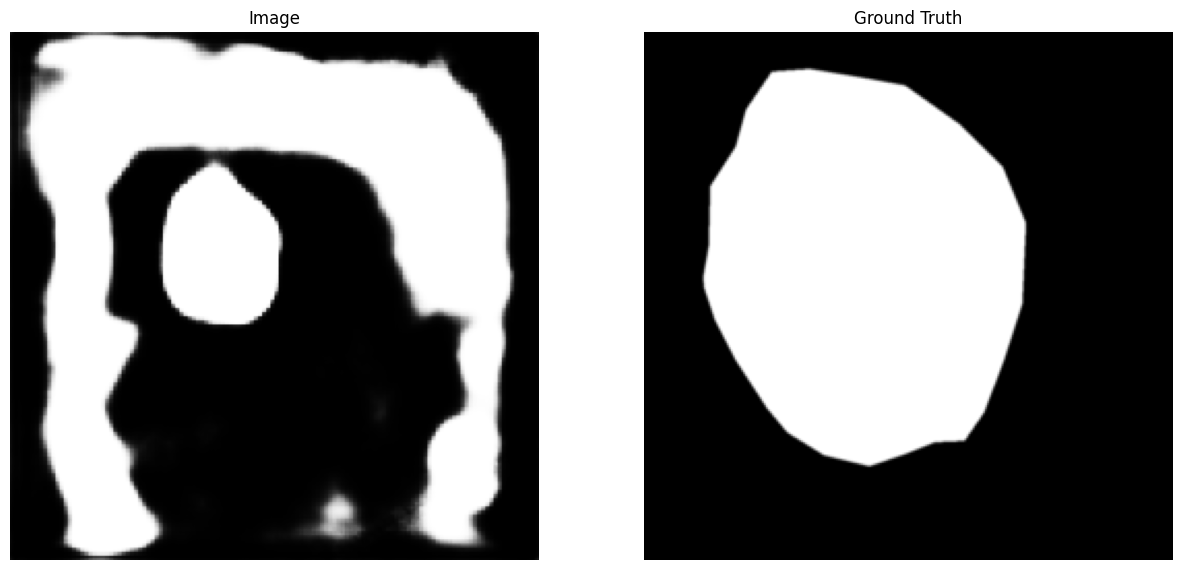

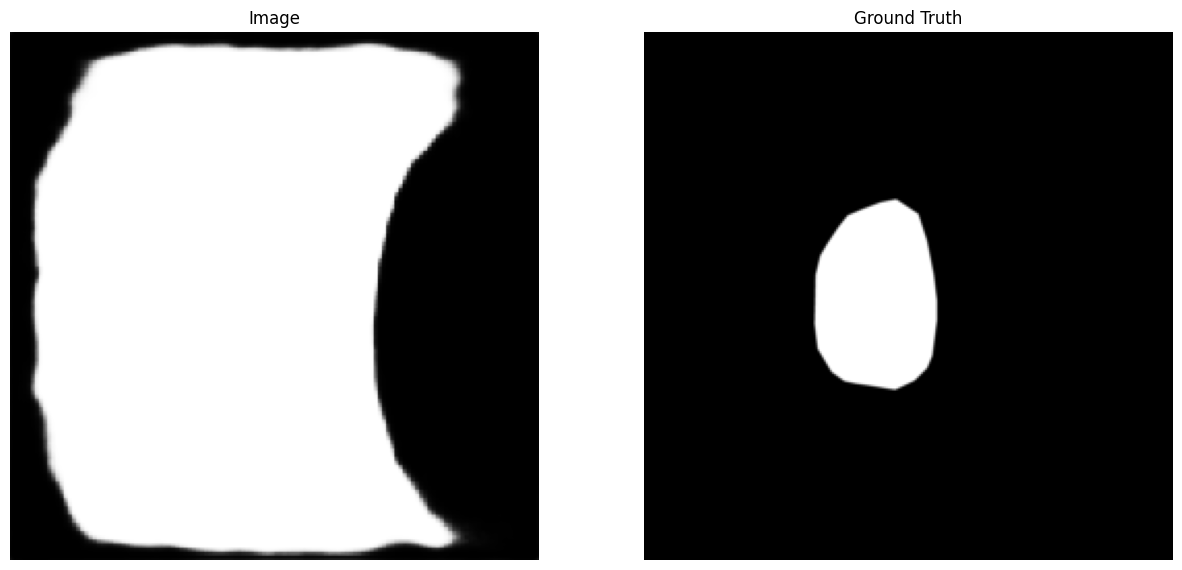

Epoch 1, Avg Loss 0.28147631883621216


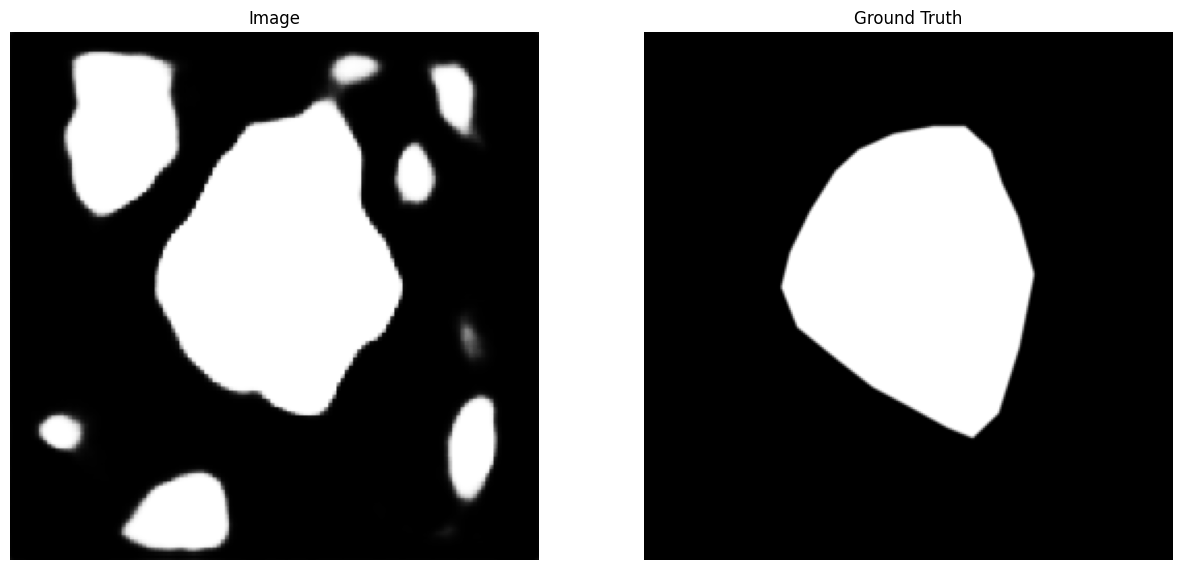

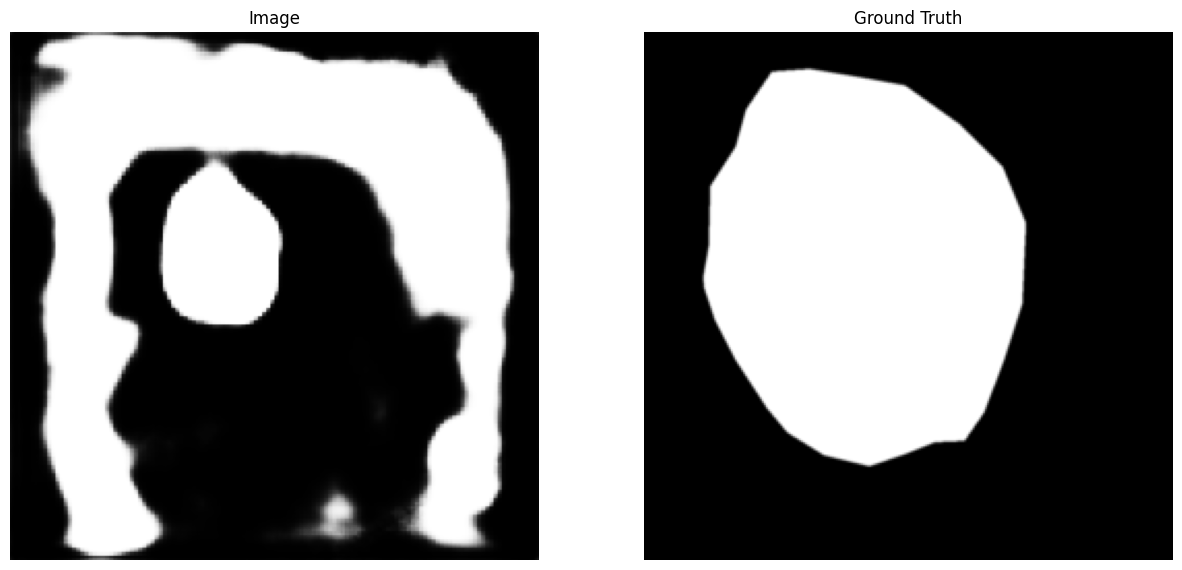

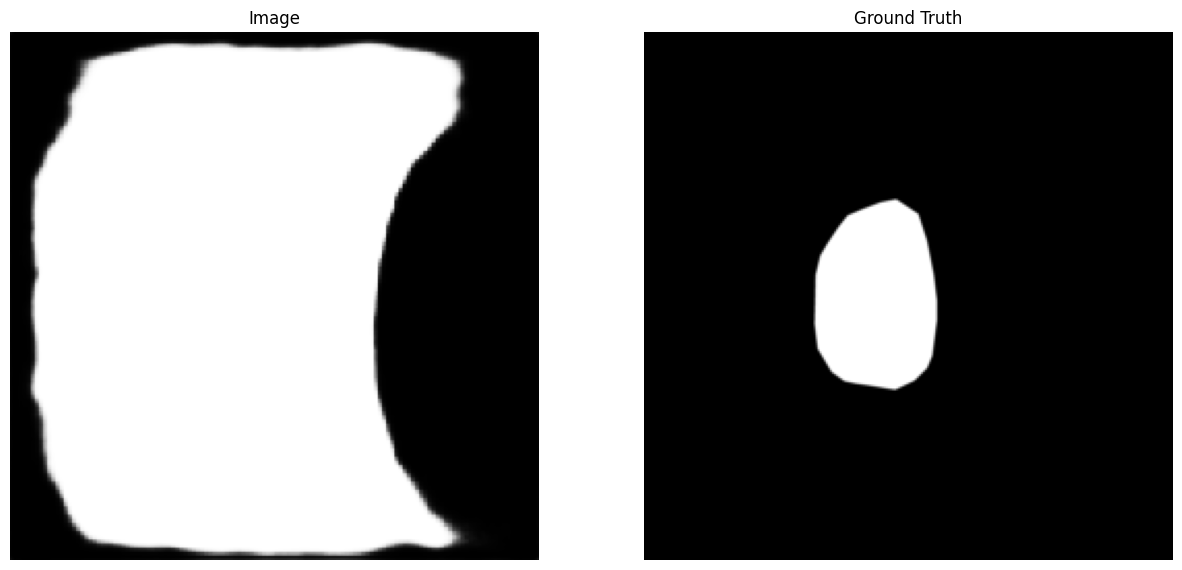

Epoch 2, Avg Loss 0.2855191844882387


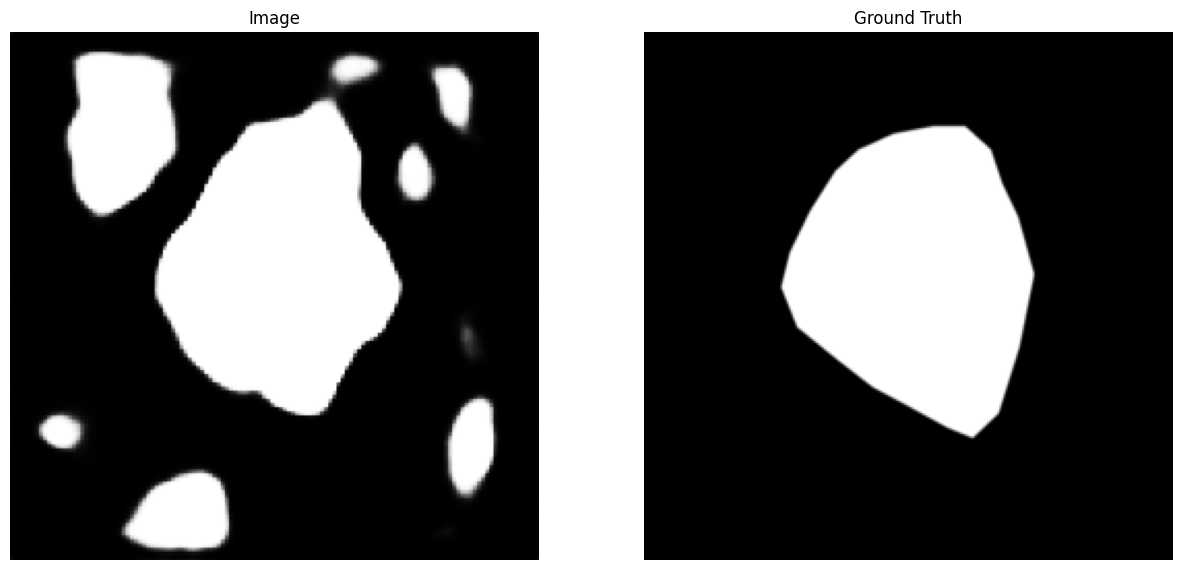

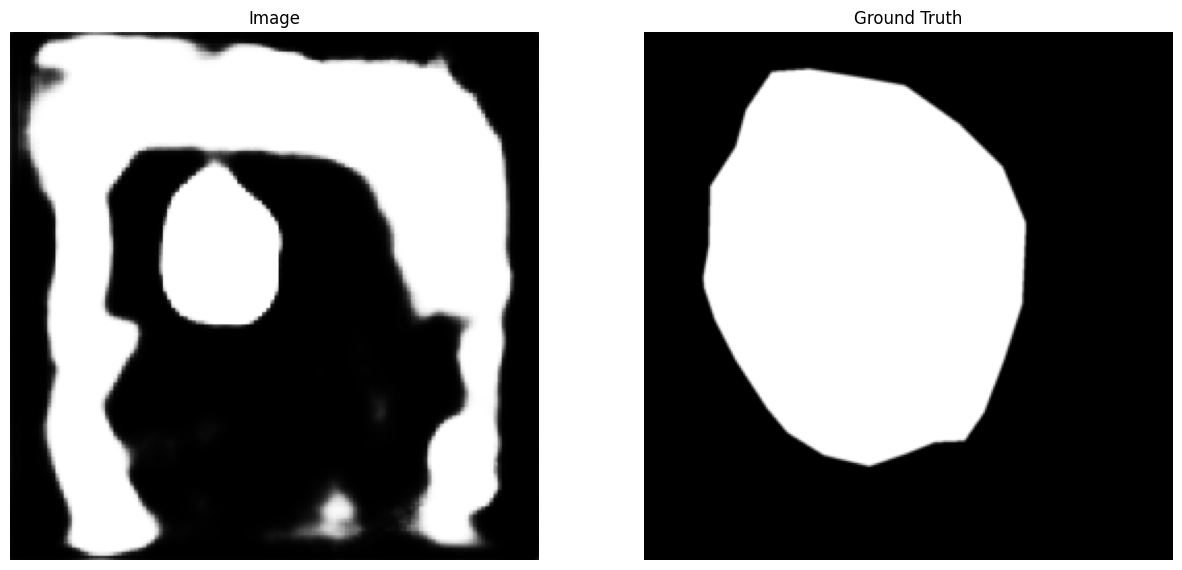

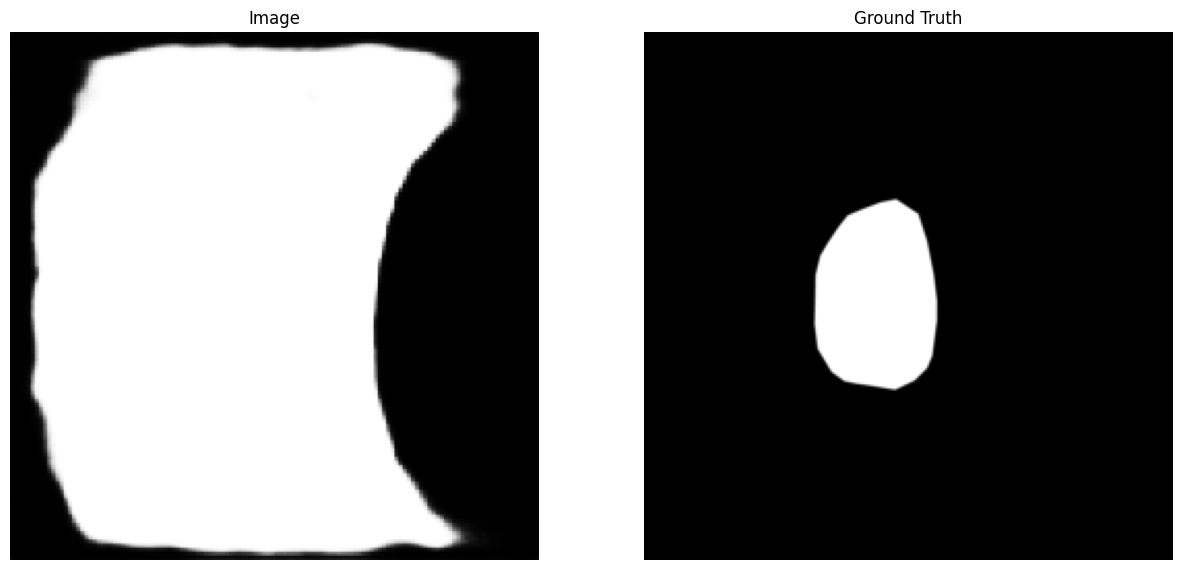

Epoch 3, Avg Loss 0.2776570428501476


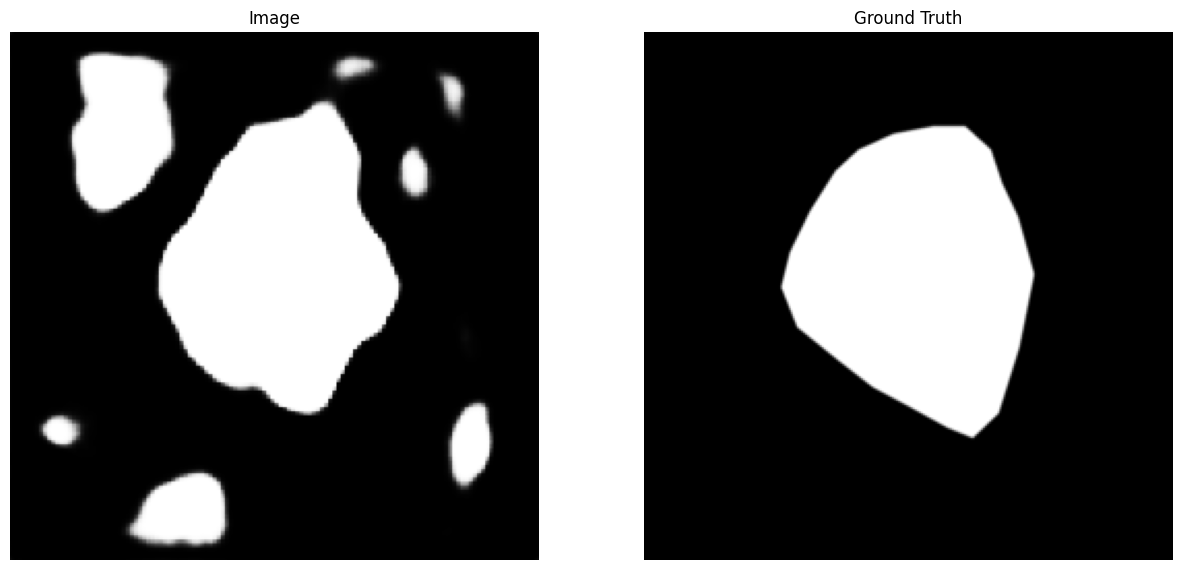

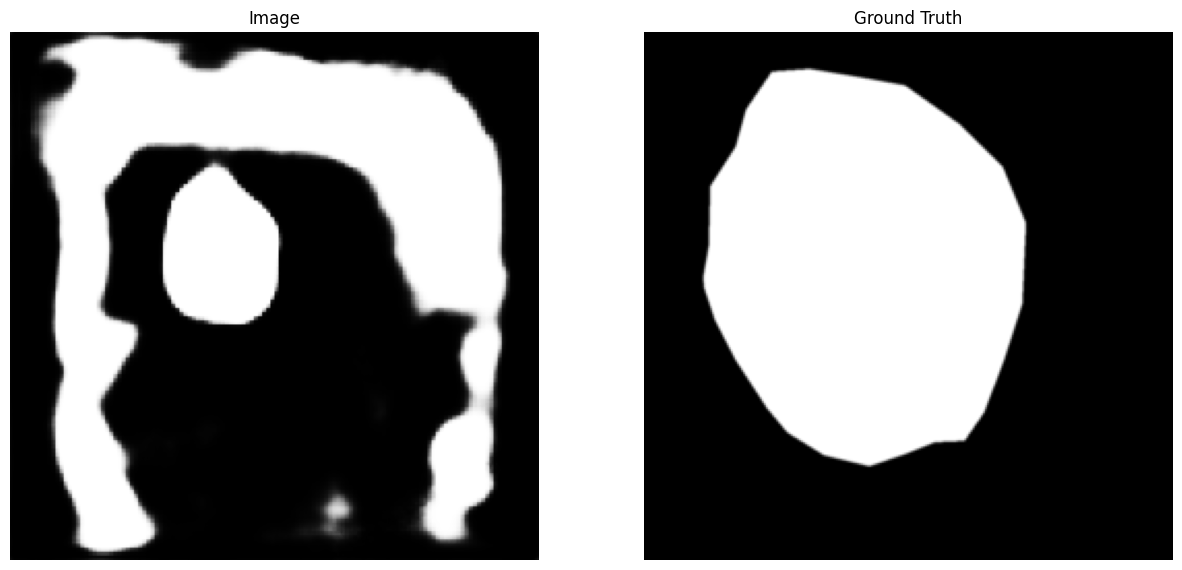

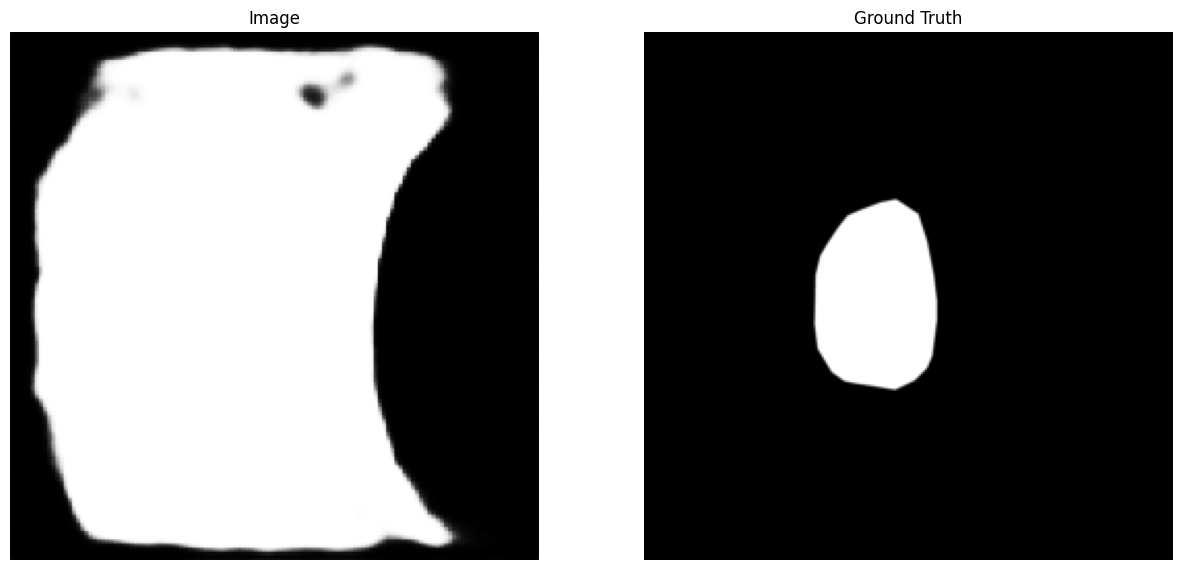

Epoch 4, Avg Loss 0.2533568902449174


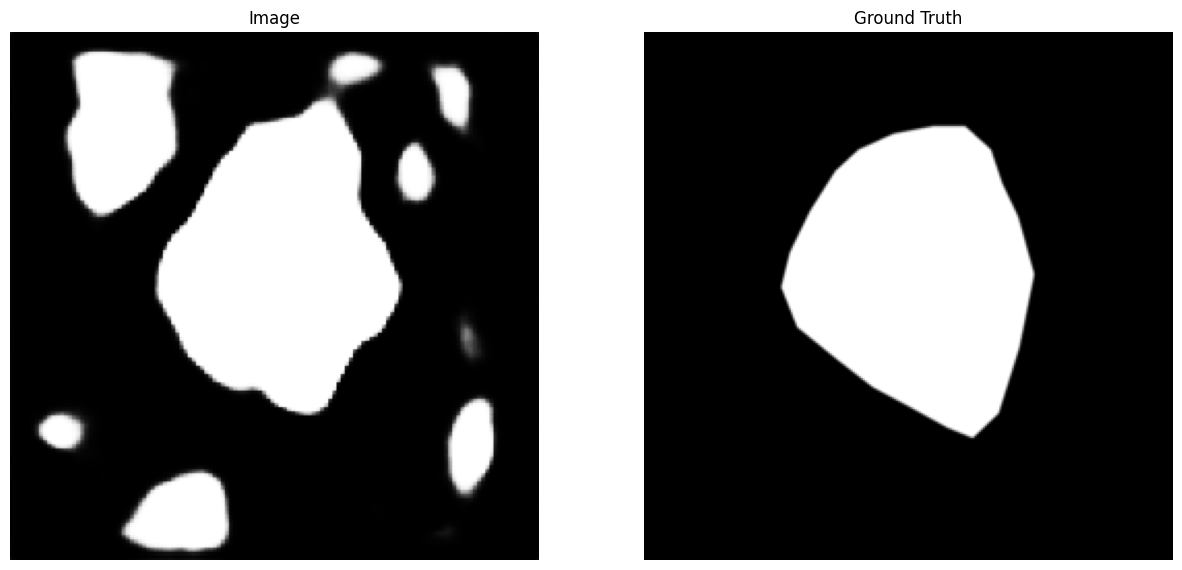

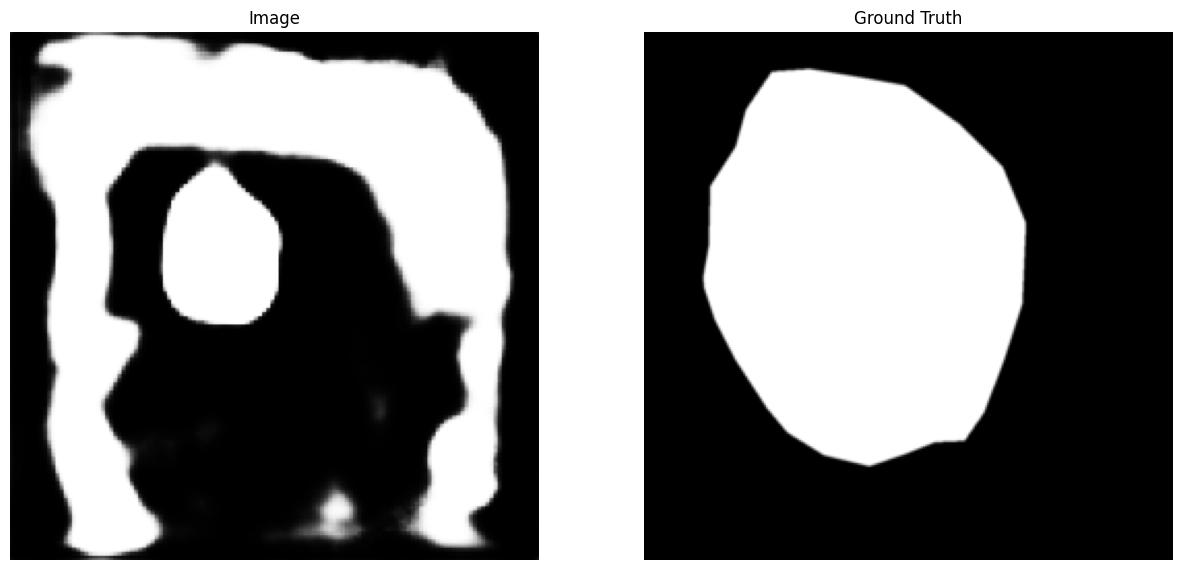

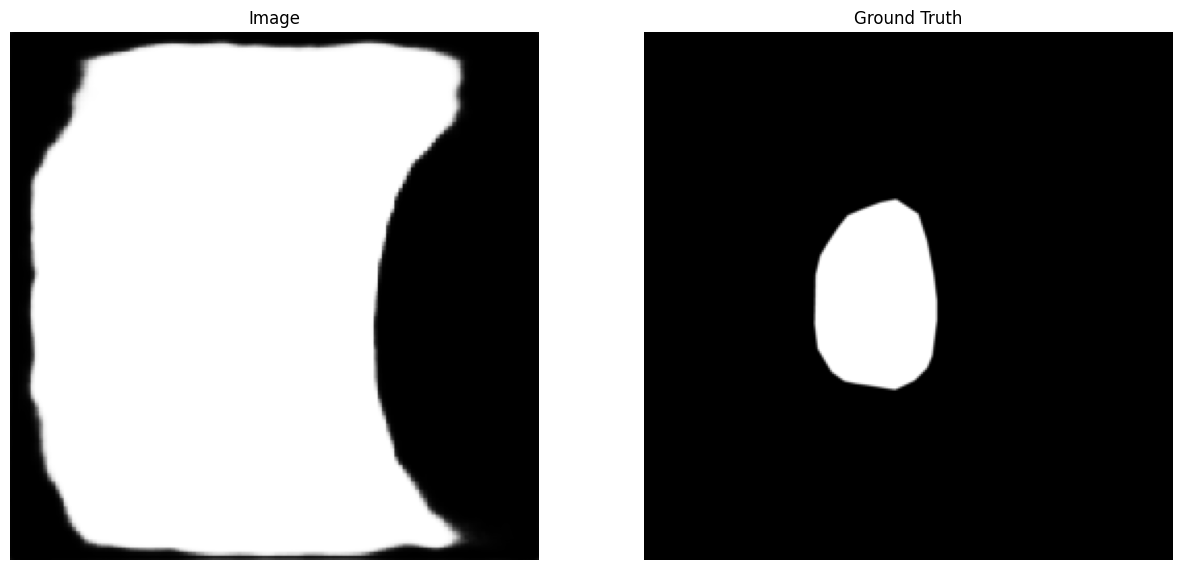

Epoch 5, Avg Loss 0.27783908266009705


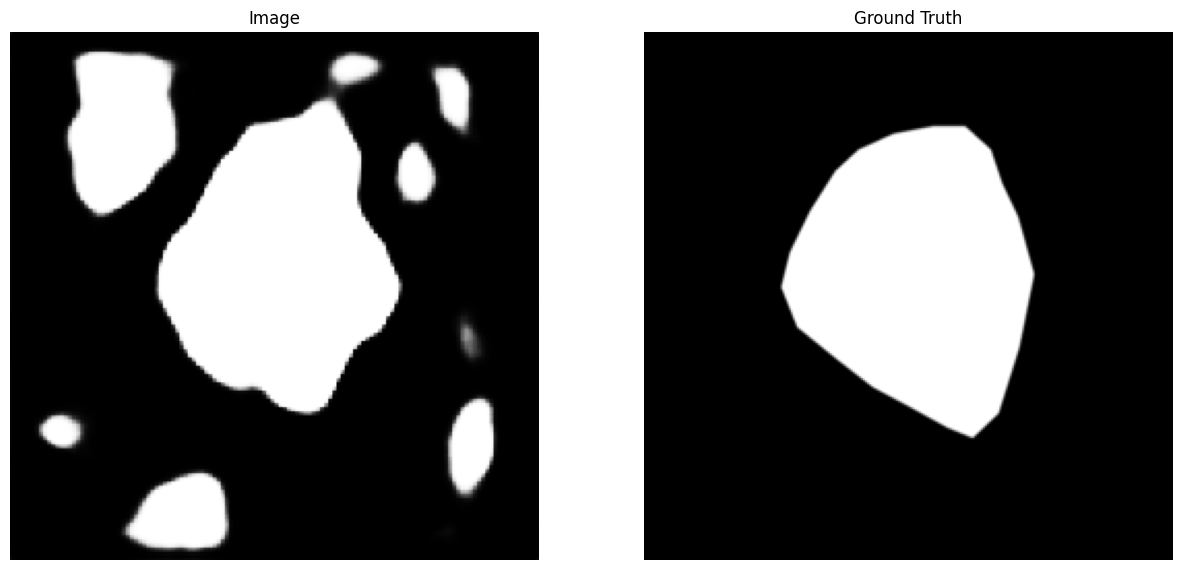

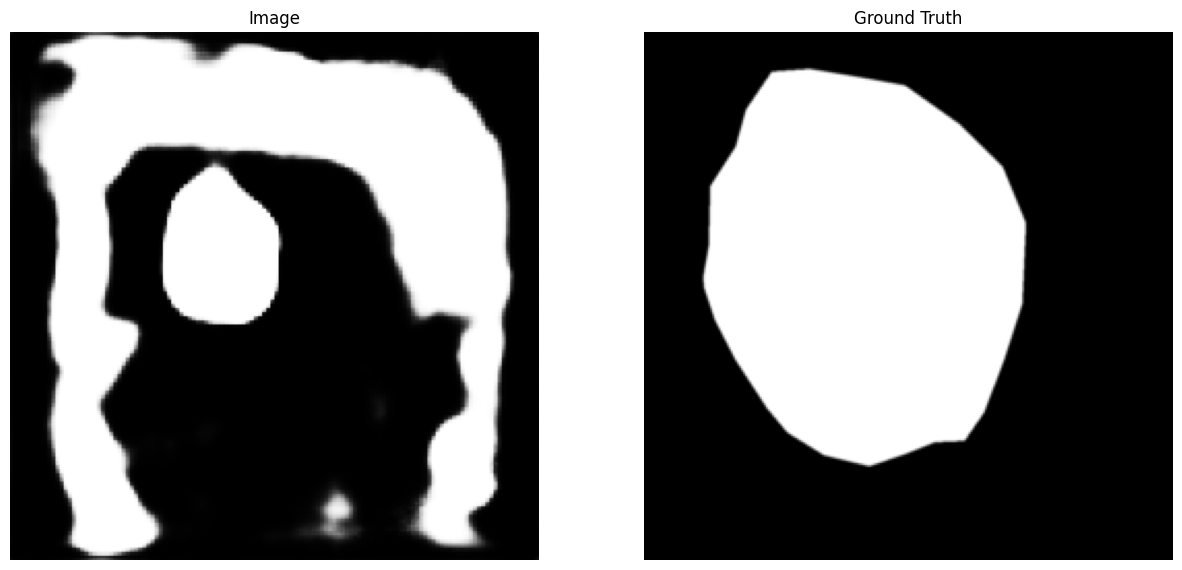

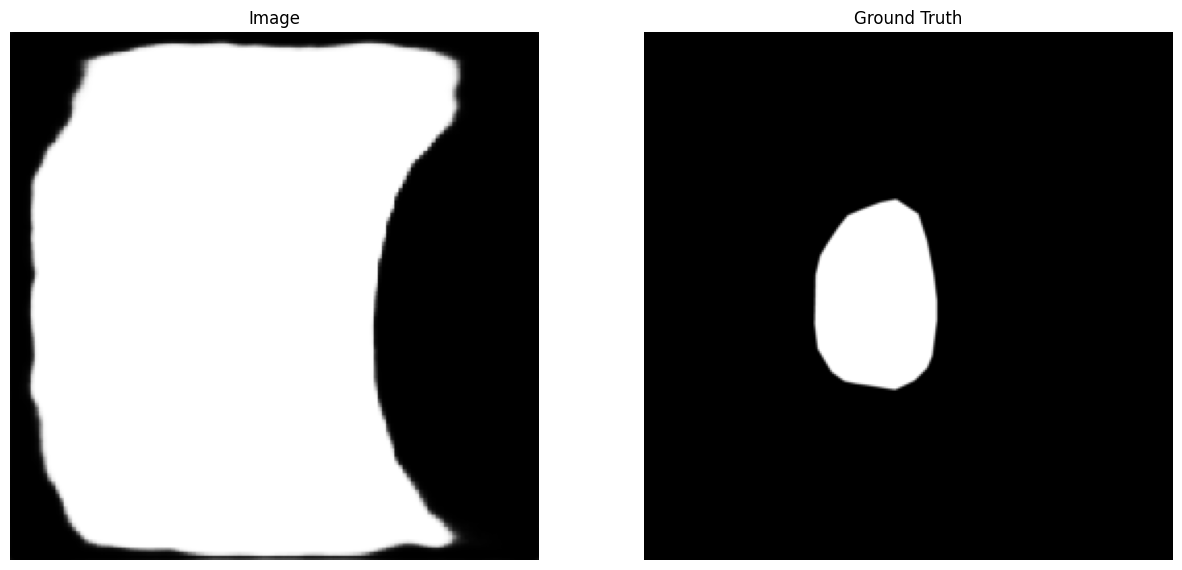

Epoch 6, Avg Loss 0.2724011648784984


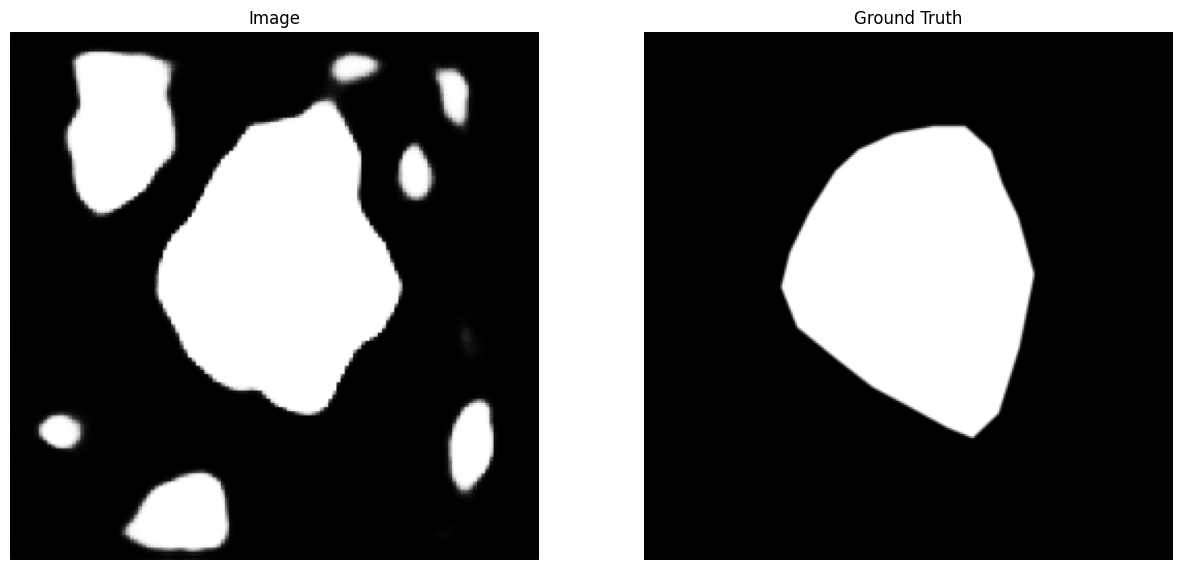

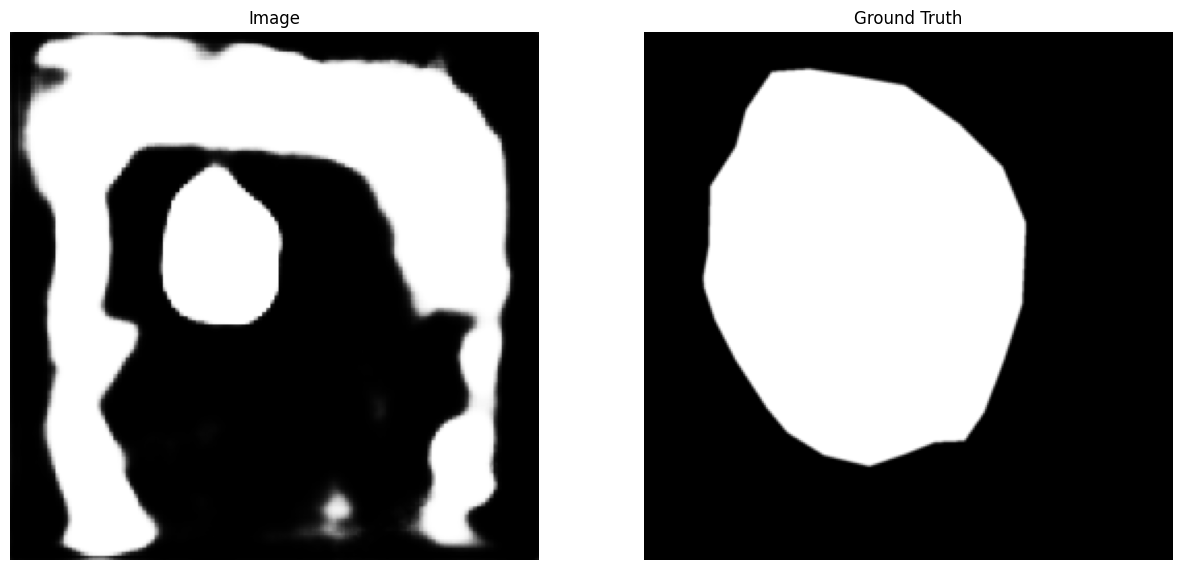

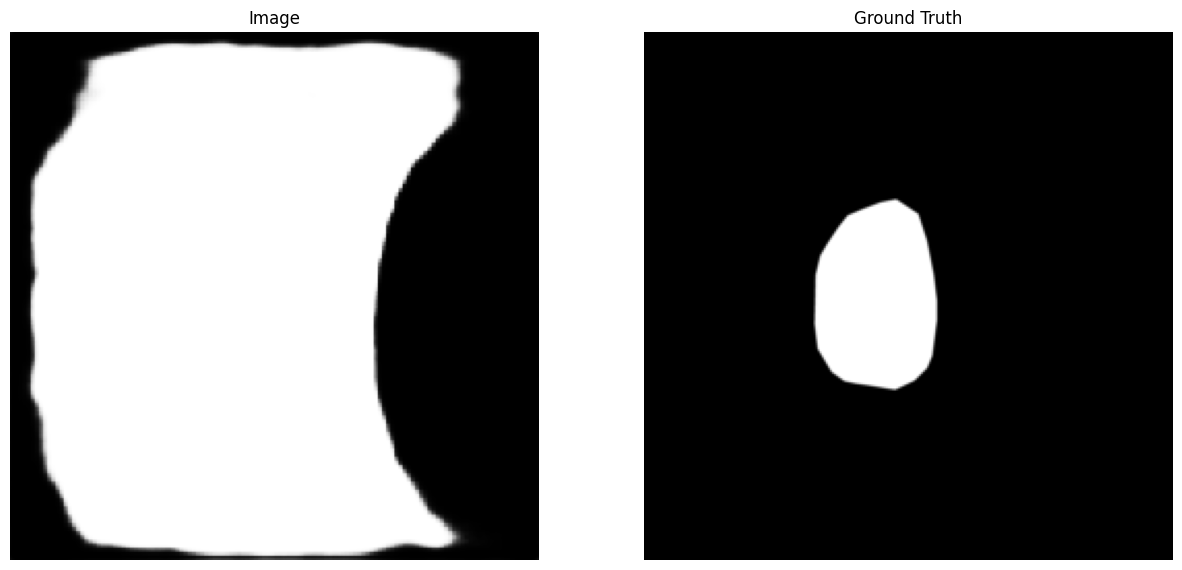

Epoch 7, Avg Loss 0.2713353922872832


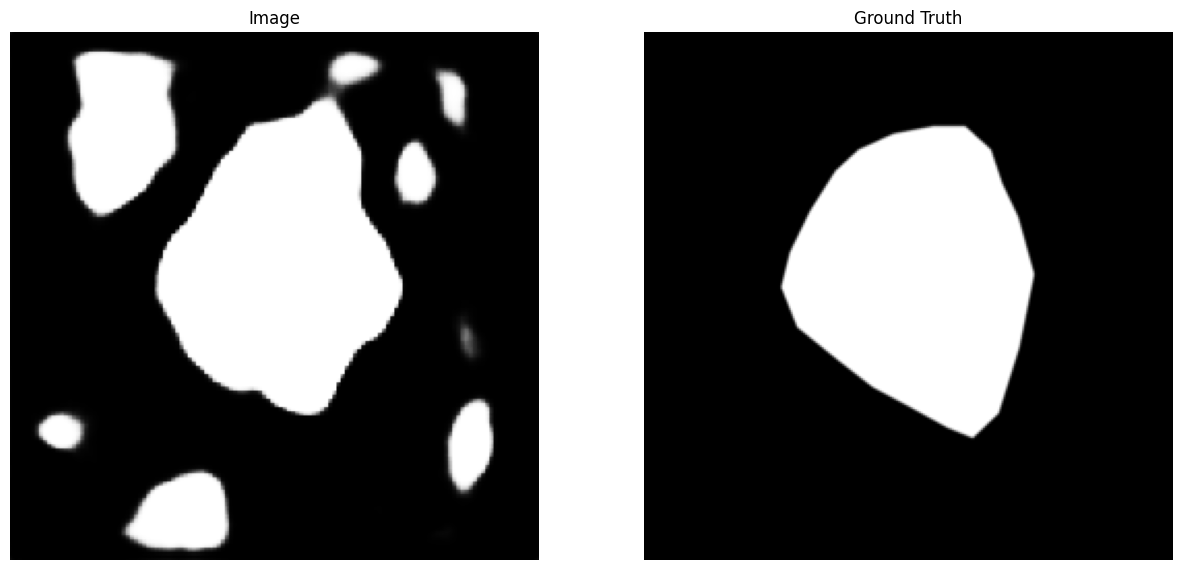

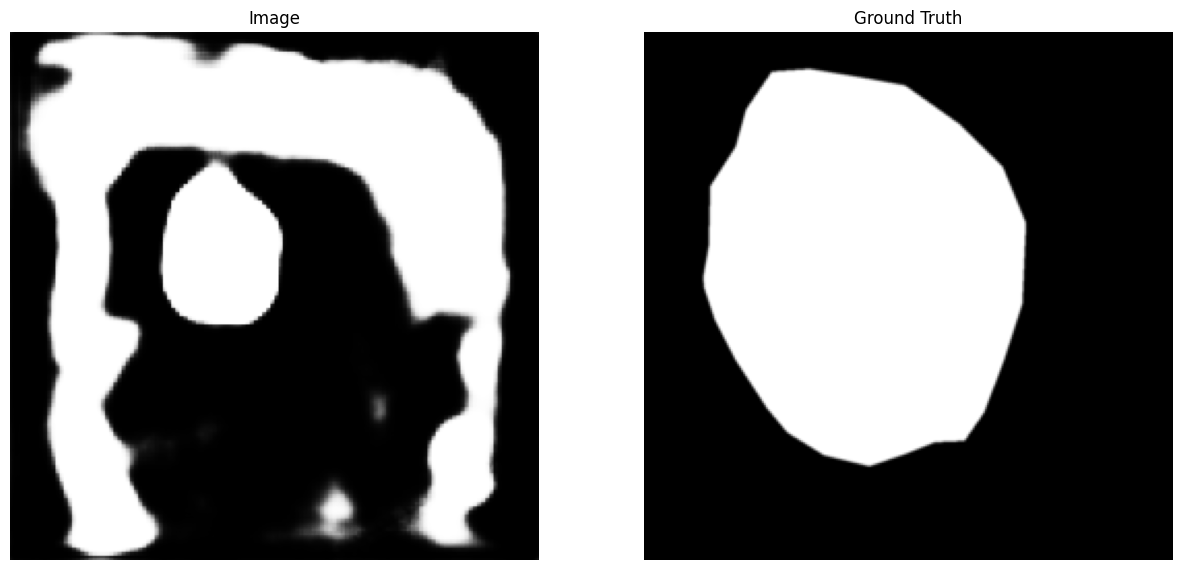

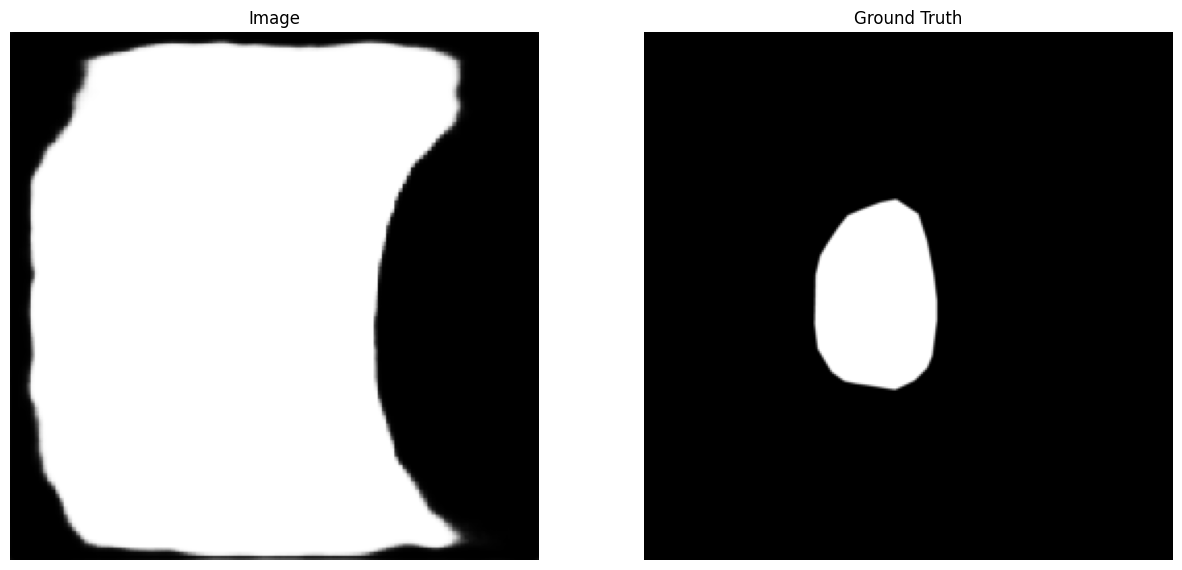

Epoch 8, Avg Loss 0.27635006471113727


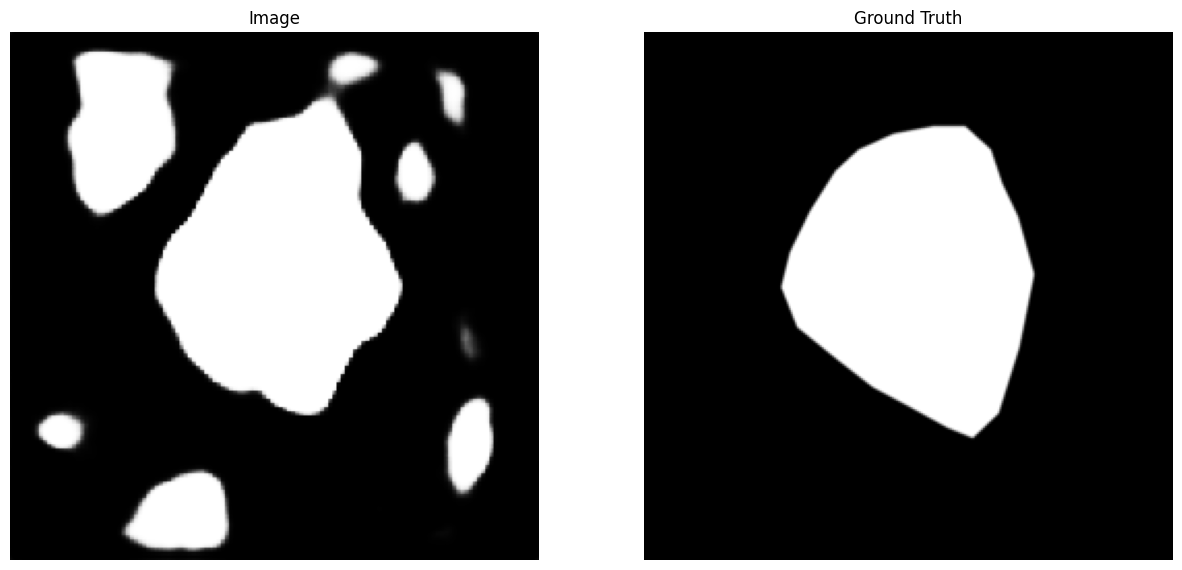

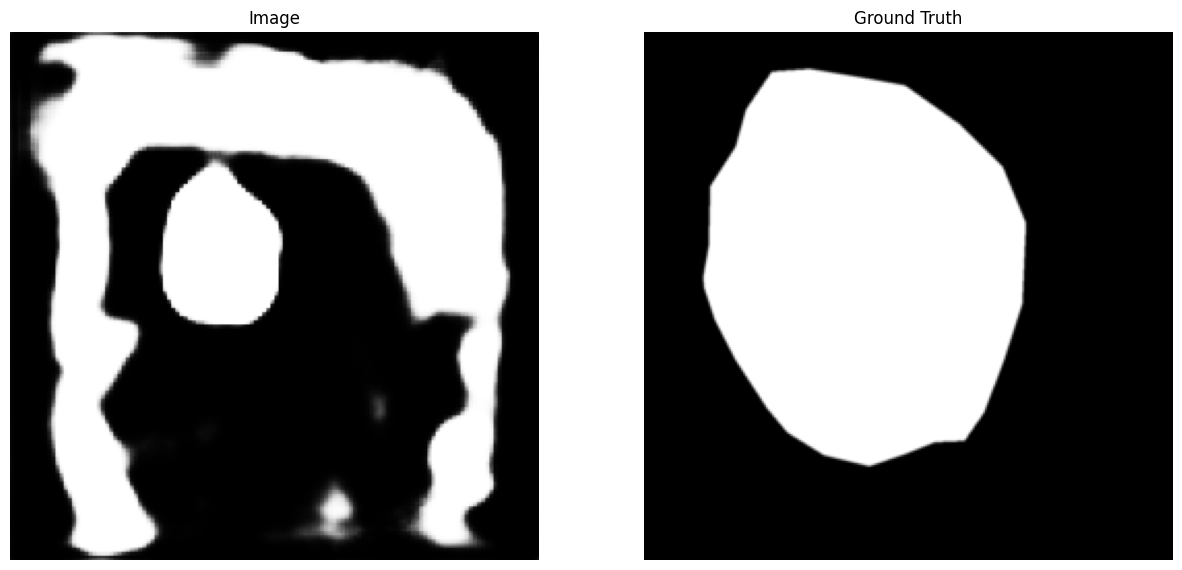

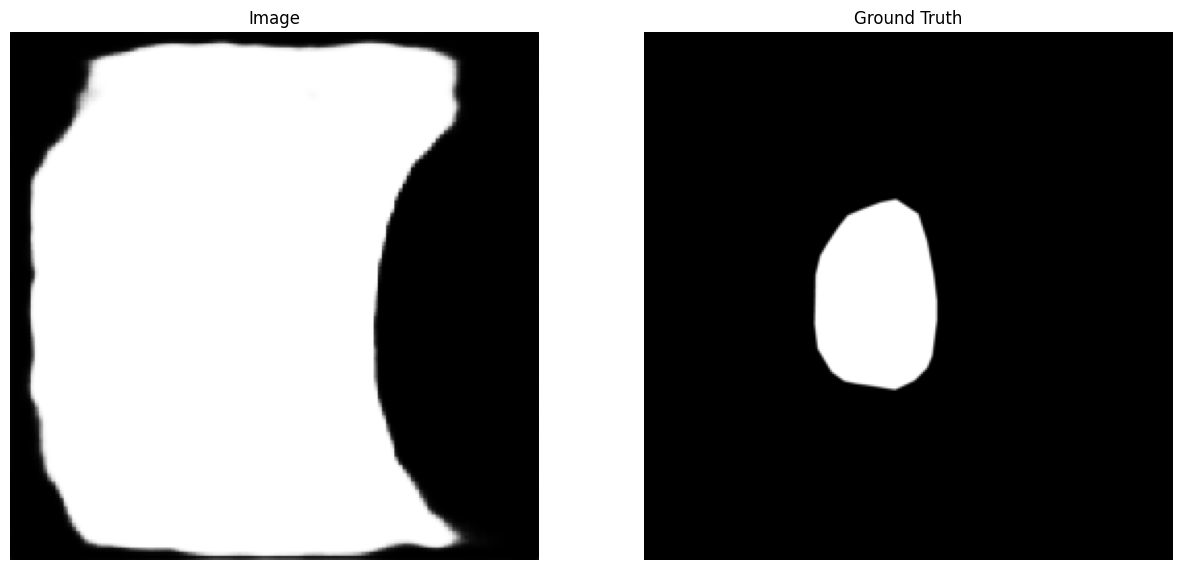

Epoch 9, Avg Loss 0.2702174186706543


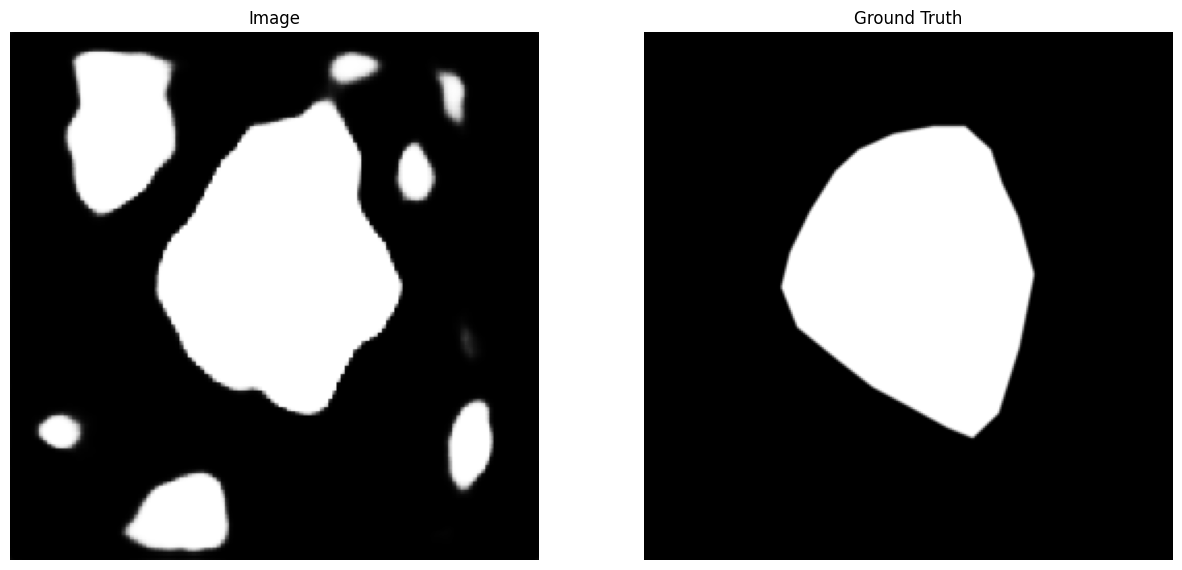

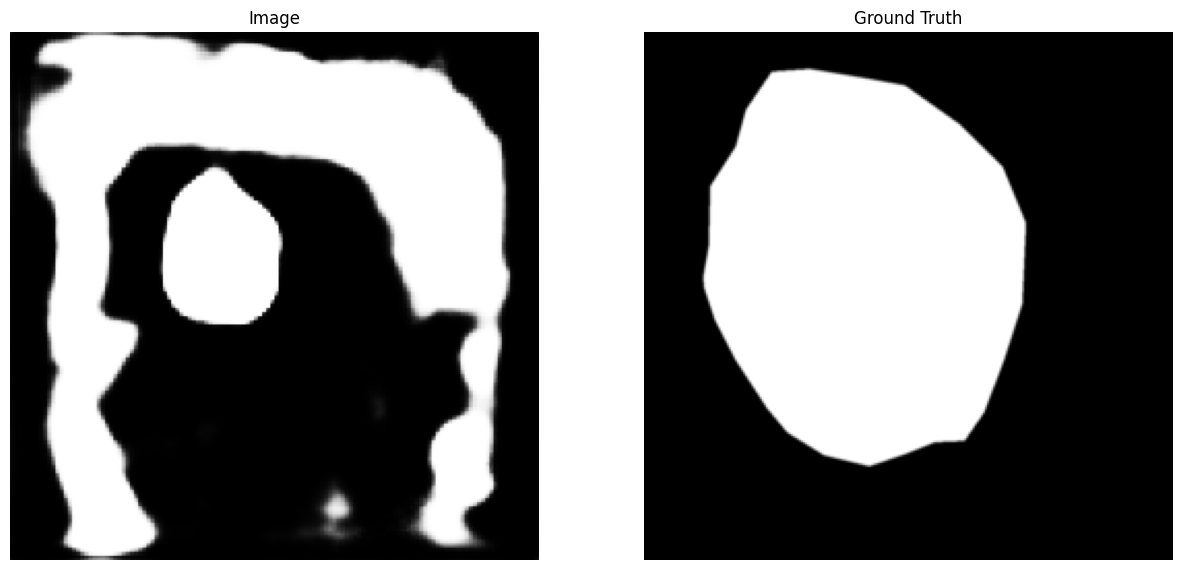

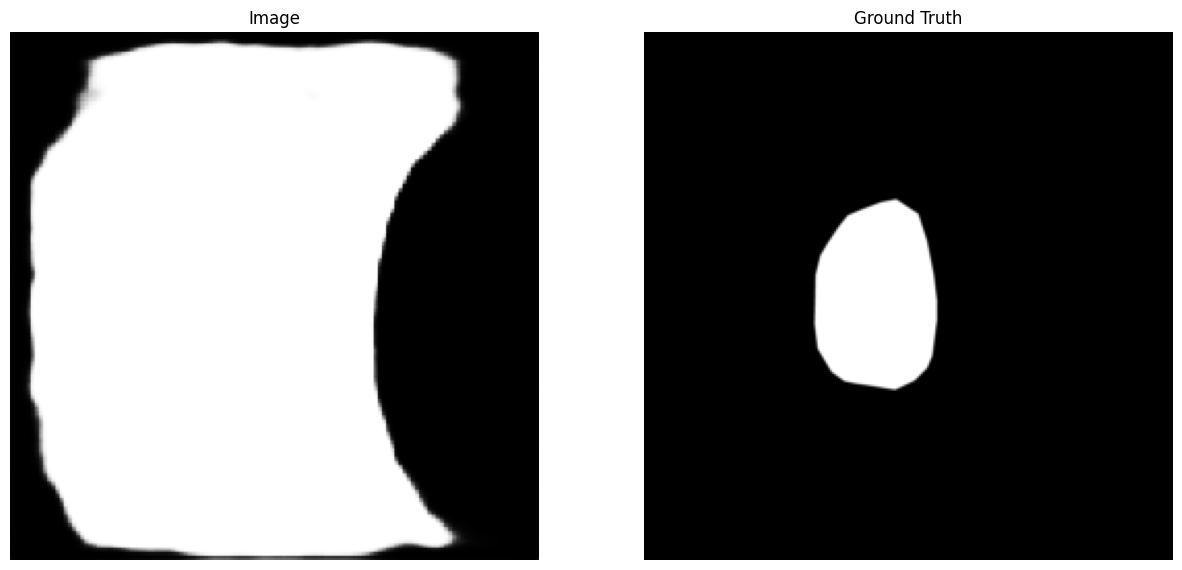

Epoch 10, Avg Loss 0.2667302128040429


In [ ]:
import matplotlib.pyplot as plt
wandb.init(project='colab ISIC run', name='just for fun')

num_epochs = 100
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0
    epoch_dice = 0
    for i, (image, truth) in enumerate(train_dataloader):
      model.train()
      image = image.to(device)
      truth = truth.to(device).float()
      optimizer.zero_grad()

      # Forward pass
      pred = model(image)

      # Calculate loss
      loss = criterion(pred, truth)

      # Backpropagation
      loss.backward()
      optimizer.step()

    for i, (image, truth) in enumerate(validation_dataloader):
      model.eval()
      image = image.to(device)
      truth = truth.to(device)
      pred = model(image)
      acc = accuracy(pred, truth)
      with torch.no_grad():
        loss = criterion(pred, truth)

      epoch_loss += loss.item()
      epoch_acc += acc
      epoch_dice += 1-loss.item()
      if i % 10 == 9:
        plt.close('all')
        image_tensor = pred.cpu().detach()
        ground = truth.cpu().detach()
        image_array = image_tensor.numpy()
        ground_array = ground.numpy()

        # Display the stacked images side by side
        plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

        plt.subplot(1, 2, 1)
        plt.imshow(image_array[0, 0], cmap='gray')  # Display the first image in image_tensor
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(ground_array[0, 0], cmap='gray')  # Display the first image in ground
        plt.title("Ground Truth")
        plt.axis('off')

        plt.show()
        wandb.log({'Batch loss': loss.item(), 'Batch accuracy': acc, 'Batch dice_score': 1-loss.item()})

    scheduler.step()
    torch.save(model.state_dict(), f'drive/MyDrive/COMP3710/colab_run_checkpoints/checkpoint{epoch}.pth')
    wandb.log({'Epoch loss': epoch_loss/len(validation_dataloader), 'Epoch accuracy': epoch_acc/len(validation_dataloader), 'Epoch dice score': epoch_dice/len(validation_dataloader)})
    print(f'Epoch {epoch+1}, Avg Loss {epoch_loss/len(validation_dataloader)}')

    torch.save(model.state_dict(), 'drive/MyDrive/COMP3710/final.pth')

In [ ]:
model2 = ImprovedUNET(3,1)
model2.load_state_dict(torch.load('drive/MyDrive/COMP3710/colab_run_checkpoints/checkpoint29.pth'))

<All keys matched successfully>

33
torch.Size([16, 1, 256, 256])


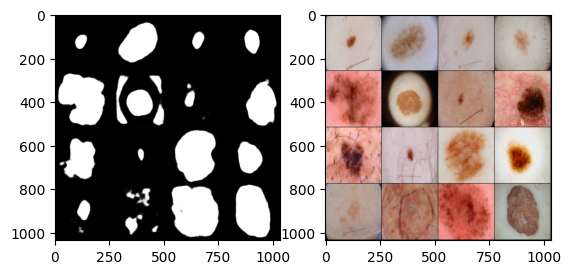

In [ ]:
import torchvision
model2.to(device)
print(len(validation_dataloader))
for image, truth in validation_dataloader:
    image = image.to(device)
    out = model2(image)
    print(out.shape)
    out_grid_img = torchvision.utils.make_grid(out.cpu(), nrow=4)
    image_grid = torchvision.utils.make_grid(image.cpu(), nrow=4)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(out_grid_img.permute(1,2,0))
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(image_grid.permute(1,2,0))
    plt.savefig('modelpredictions.png')
    plt.show()
    break